# import 

In [1]:
import time
import glob
import datetime
import random
import pickle
import numpy as np
import shutil
import os
import sklearn
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
np.random.seed(1) # (A)
import keras.optimizers  # (B)
from keras.models import Sequential # (C)
from keras.layers.core import Dense, Activation #(D)
from keras.layers.normalization import BatchNormalization
from keras.utils.np_utils import to_categorical
from decimal import *
from keras.layers.recurrent import SimpleRNN, LSTM
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical
from keras.layers import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn import datasets
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split,GridSearchCV
from keras.layers import Embedding
from keras.wrappers.scikit_learn import KerasClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score  
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from tensorflow.python.keras.models import load_model
import statsmodels.graphics.api as smg
from statsmodels.graphics.tsaplots import plot_acf
from scipy import stats
from scipy.stats import f
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report, accuracy_score

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


# class load df

In [2]:
class DataFramePreProcessing():

    
    def __init__(self, path_, is_daw=False):
        self.path_ = path_
        self.is_daw = is_daw

        
    def load_df(self):
        if self.is_daw:
            d='d'
        else:
            d=''
        FILE = glob.glob(self.path_)
        df = pd.read_csv(FILE[0])
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:d+'open',\
                                    df.columns[6]:d+'high',df.columns[7]:d+'low',df.columns[8]:d+'close',\
                                       df.columns[9]:d+'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)

        return df.astype(float)

# class Make train datta one hot

In [35]:



class MakeTrainData2OneHot():
    
    
    def __init__(self, df_con, test_rate, column, questions_index = [], is_bit_search=False,is_category=True):
        self.df_con = df_con
        self.test_rate = test_rate
        self.column = column
        self.questions_index = questions_index
        self.is_bit_search = is_bit_search
        self.is_category = is_category
        
        
    def labeling(self):
        if self.is_category:
            up=1
            down=0
        else:
            up=[0,1]
            down=[1,0]
        
        
        return up,down
    
    
    def append_onehotlist(self, one_hot_list, questions):
        for i in range(len(questions)):
            if questions[i]:
                one_hot_list.append(1)
            else:
                one_hot_list.append(0)
                
                
    
    def make_analog_data(self):
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.column)
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(day_sride+1,len(self.df_con)-1):
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
            
            
    # ---------------Question----------------
            questions = [
                dawp_1
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            dfx.loc[i-5] = selected_questions
            tommorow_close = self.df_con['close'].iloc[i+1]
            today_close    = self.df_con['close'].iloc[i]
            if tommorow_close>today_close:
                df_ans.append(up)
            else:
                df_ans.append(down)
                
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        y_train = df_ans[:int(len(dfx)*self.test_rate)]
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        y_test  = df_ans[int(len(dfx)*self.test_rate):]
        
        return x_train, y_train, x_test, y_test
    
    
    
    def make_data(self):
     
        selected_column = []
        if self.is_bit_search:
            for i in self.questions_index:
                selected_column.append(self.column[i])
            dfx = pd.DataFrame(columns = selected_column)
        else:
            dfx = pd.DataFrame(columns = self.column)
        df_tpx_p = self.df_con['close'].pct_change()
        df_ans = []
        day_sride = 5 # 何日前まで見るか　
                      # default = 5
                        
        up, down = self.labeling()
        for i in range(day_sride+1,len(self.df_con)-1):
#       df_con.index.weekday[i]
#       index.weekday[i] Mon:0 ~ Sun:6
#       df_daw.columns[0]=='dopen'
#       df_daw.columns[1]=='dhigh'
#       df_daw.columns[2]=='dlow'
#       df_daw.columns[3]=='dclose'
#       yesterday t-1 = i-1
#       today t = i
            one_hot_list = []
            dawp_5 = self.df_con['dclose'].iloc[i-4]
            dawp_4 = self.df_con['dclose'].iloc[i-3]
            dawp_3 = self.df_con['dclose'].iloc[i-2]
            dawp_2 = self.df_con['dclose'].iloc[i-1]
            dawp_1 = self.df_con['dclose'].iloc[i]
            nikkeip_5 = df_tpx_p.iloc[i-4]
            nikkeip_4 = df_tpx_p.iloc[i-3]
            nikkeip_3 = df_tpx_p.iloc[i-2]
            nikkeip_2 = df_tpx_p.iloc[i-1]
            nikkeip_1 = df_tpx_p.iloc[i]
            
            diff_high_low = self.df_con['high'].iloc[i] - \
                            self.df_con['low'].iloc[i]
            diff_rate = diff_high_low / self.df_con['close'].iloc[i]
            nikkei_volumep = (self.df_con['volume'].iloc[i] - self.df_con['volume'].iloc[i-1])\
            /self.df_con['volume'].iloc[i-1]
   
    # ---------------Question----------------
            questions = [

                0.1>=dawp_5*100>0,
                0.1>=dawp_4*100>0,
                0.1>=dawp_3*100>0,
                0.1>=dawp_2*100>0,
                0.1>=dawp_1*100>0,
                
                0.2>=dawp_5*100>0.1,
                0.2>=dawp_4*100>0.1,
                0.2>=dawp_3*100>0.1,
                0.2>=dawp_2*100>0.1,
                0.2>=dawp_1*100>0.1,
                
                0.3>=dawp_5*100>0.2,
                0.3>=dawp_4*100>0.2,
                0.3>=dawp_3*100>0.2,
                0.3>=dawp_2*100>0.2,
                0.3>=dawp_1*100>0.2,
                
                0.4>=dawp_5*100>0.3,
                0.4>=dawp_4*100>0.3,
                0.4>=dawp_3*100>0.3,
                0.4>=dawp_2*100>0.3,
                0.4>=dawp_1*100>0.3,
                
                0.5>=dawp_5*100>0.4,
                0.5>=dawp_4*100>0.4,
                0.5>=dawp_3*100>0.4,
                0.5>=dawp_2*100>0.4,
                0.5>=dawp_1*100>0.4,
                
                
                0.75>=dawp_5*100>0.5,
                0.75>=dawp_4*100>0.5,
                0.75>=dawp_3*100>0.5,
                0.75>=dawp_2*100>0.5,
                0.75>=dawp_1*100>0.5,
                
                1.0>=dawp_5*100>0.75,
                1.0>=dawp_4*100>0.75,
                1.0>=dawp_3*100>0.75,
                1.0>=dawp_2*100>0.75,
                1.0>=dawp_1*100>0.75,
                
                
                
                
                1.5>=dawp_5*100>1.0,
                1.5>=dawp_4*100>1.0,
                1.5>=dawp_3*100>1.0,
                1.5>=dawp_2*100>1.0,
                1.5>=dawp_1*100>1.0, 
                
                dawp_5*100>1.5,
                dawp_4*100>1.5,
                dawp_3*100>1.5,
                dawp_2*100>1.5,
                dawp_1*100>1.5,
                
                -0.1<dawp_5*100<=0,
                -0.1<dawp_4*100<=0,
                -0.1<dawp_3*100<=0,
                -0.1<dawp_2*100<=0,
                -0.1<dawp_1*100<=0,
                
                -0.2<dawp_5*100<=-0.1,
                -0.2<dawp_4*100<=-0.1,
                -0.2<dawp_3*100<=-0.1,
                -0.2<dawp_2*100<=-0.1,
                -0.2<dawp_1*100<=-0.1,
                
                -0.3<dawp_5*100<=-0.2,
                -0.3<dawp_4*100<=-0.2,
                -0.3<dawp_3*100<=-0.2,
                -0.3<dawp_2*100<=-0.2,
                -0.3<dawp_1*100<=-0.2,
                
                -0.4<dawp_5*100<=-0.3,
                -0.4<dawp_4*100<=-0.3,
                -0.4<dawp_3*100<=-0.3,
                -0.4<dawp_2*100<=-0.3,
                -0.4<dawp_1*100<=-0.3,
                
                -0.5<dawp_5*100<=-0.4,
                -0.5<dawp_4*100<=-0.4,
                -0.5<dawp_3*100<=-0.4,
                -0.5<dawp_2*100<=-0.4,
                -0.5<dawp_1*100<=-0.4,
              
                -0.75<dawp_5*100<=-0.5,
                -0.75<dawp_4*100<=-0.5,
                -0.75<dawp_3*100<=-0.5,
                -0.75<dawp_2*100<=-0.5,
                -0.75<dawp_1*100<=-0.5,
                
                -1.0<dawp_5*100<=-0.75,
                -1.0<dawp_4*100<=-0.75,
                -1.0<dawp_3*100<=-0.75,
                -1.0<dawp_2*100<=-0.75,
                -1.0<dawp_1*100<=-0.75,
                
                -1.5<dawp_5*100<=-1.0,
                -1.5<dawp_4*100<=-1.0,
                -1.5<dawp_3*100<=-1.0,
                -1.5<dawp_2*100<=-1.0,
                -1.5<dawp_1*100<=-1.0,
               
                dawp_5*100<=-1.5,
                dawp_4*100<=-1.5,
                dawp_3*100<=-1.5,
                dawp_2*100<=-1.5,
                dawp_1*100<=-1.5,

#       1 ################
                0.25>=nikkeip_5*100>0,
                0.25>=nikkeip_4*100>0,
                0.25>=nikkeip_3*100>0,
                0.25>=nikkeip_2*100>0,
                0.25>=nikkeip_1*100>0,
                
                0.5>=nikkeip_5*100>0.25,
                0.5>=nikkeip_4*100>0.25,
                0.5>=nikkeip_3*100>0.25,
                0.5>=nikkeip_2*100>0.25,
                0.5>=nikkeip_1*100>0.25,
                
                0.75>=nikkeip_5*100>0.5,
                0.75>=nikkeip_4*100>0.5,
                0.75>=nikkeip_3*100>0.5,
                0.75>=nikkeip_2*100>0.5,
                0.75>=nikkeip_1*100>0.5,
                
                1.0>=nikkeip_5*100>0.75,
                1.0>=nikkeip_4*100>0.75,
                1.0>=nikkeip_3*100>0.75,
                1.0>=nikkeip_2*100>0.75,
                1.0>=nikkeip_1*100>0.75,
                
                1.5>=nikkeip_5*100>1.0,
                1.5>=nikkeip_4*100>1.0,
                1.5>=nikkeip_3*100>1.0,
                1.5>=nikkeip_2*100>1.0,
                1.5>=nikkeip_1*100>1.0,
                
                2.0>=nikkeip_5*100>1.5,
                2.0>=nikkeip_4*100>1.5,
                2.0>=nikkeip_3*100>1.5,
                2.0>=nikkeip_2*100>1.5,
                2.0>=nikkeip_1*100>1.5,
                
                
#    1 #######              
                nikkeip_5*100>2.0,
                nikkeip_4*100>2.0,
                nikkeip_3*100>2.0,
                nikkeip_2*100>2.0,
                nikkeip_1*100>2.0,
           
#    2
                -0.25<nikkeip_5*100<=0,
                -0.25<nikkeip_4*100<=0,
                -0.25<nikkeip_3*100<=0,
                -0.25<nikkeip_2*100<=0,
                -0.25<nikkeip_1*100<=0,
                
                -0.5<nikkeip_5*100<=-0.25,
                -0.5<nikkeip_4*100<=-0.25,
                -0.5<nikkeip_3*100<=-0.25,
                -0.5<nikkeip_2*100<=-0.25,
                -0.5<nikkeip_1*100<=-0.25,
                
                -1.0<nikkeip_5*100<=-0.5,
                -1.0<nikkeip_4*100<=-0.5,
                -1.0<nikkeip_3*100<=-0.5,
                -1.0<nikkeip_2*100<=-0.5,
                -1.0<nikkeip_1*100<=-0.5,
                
                -1.5<nikkeip_5*100<=-1.0,
                -1.5<nikkeip_4*100<=-1.0,
                -1.5<nikkeip_3*100<=-1.0,
                -1.5<nikkeip_2*100<=-1.0,
                -1.5<nikkeip_1*100<=-1.0,
                
#     2
                
                -2.0<nikkeip_5*100<=-1.5,
                -2.0<nikkeip_4*100<=-1.5,
                -2.0<nikkeip_3*100<=-1.5,
                -2.0<nikkeip_2*100<=-1.5,
                -2.0<nikkeip_1*100<=-1.5,
                
                nikkeip_5*100<=-2.0,
                nikkeip_4*100<=-2.0,
                nikkeip_3*100<=-2.0,
                nikkeip_2*100<=-2.0,
                nikkeip_1*100<=-2.0,
                
#                 3

                nikkei_volumep*100>=80,
                80>nikkei_volumep*100>=70,
                70>nikkei_volumep*100>=60,
                60>nikkei_volumep*100>=50,
                40>nikkei_volumep*100>=30,
                30>nikkei_volumep*100>=20,
                20>nikkei_volumep*100>=10,
                10>nikkei_volumep*100>=0,
                
               
                -10<nikkei_volumep*100<=0,
                -20<nikkei_volumep*100<=-10,
                -30<nikkei_volumep*100<=-20,
                -40<nikkei_volumep*100<=-30,
                -50<nikkei_volumep*100<=-40,
                nikkei_volumep*100<=-50,
                
                                
                
                0.5>=diff_rate*100>0,
                0.55>=diff_rate*100>0.5,
                0.60>=diff_rate*100>0.55,
                0.65>=diff_rate*100>0.60,
                0.7>=diff_rate*100>0.65,
                0.75>=diff_rate*100>0.7,
                
                0.8>=diff_rate*100>0.75,
                0.85>=diff_rate*100>0.8,
                0.9>=diff_rate*100>0.85,
                0.95>=diff_rate*100>0.9,
                1.0>=diff_rate*100>0.95,
                1.15>=diff_rate*100>1.0,
                1.20>=diff_rate*100>1.15,
                1.25>=diff_rate*100>1.2,
                1.5>=diff_rate*100>1.25,
                2.0>=diff_rate*100>1.5,
                diff_rate*100>2.0,
# 3
              
            ]
        
            
            if self.is_bit_search:
                selected_questions = []
                for j in self.questions_index:
                    selected_questions.append(questions[j])
                    
            else:
                selected_questions = questions


            self.append_onehotlist(one_hot_list, selected_questions)
            dfx.loc[i-5] = one_hot_list
            tommorow_close = self.df_con['close'].iloc[i+1]
            today_close    = self.df_con['close'].iloc[i]
            if tommorow_close>today_close:
                df_ans.append(up)
            else:
                df_ans.append(down)
                
        x_train = dfx.iloc[:int(len(dfx)*self.test_rate)]
        y_train = pd.Series(df_ans[:int(len(dfx)*self.test_rate)])
        x_test  = dfx.iloc[int(len(dfx)*self.test_rate):]
        y_test  = pd.Series(df_ans[int(len(dfx)*self.test_rate):])
        
        return x_train, y_train, x_test, y_test
    
    


# list questions

In [34]:
all_questions_column = [
                
                '0.1bedawp_5*100bt0',
                '0.1bedawp_4*100bt0',
                '0.1bedawp_3*100bt0',
                '0.1bedawp_2*100bt0',
                '0.1bedawp_1*100bt0',
                
                '0.2bedawp_5*100bt0.1',
                '0.2bedawp_4*100bt0.1',
                '0.2bedawp_3*100bt0.1',
                '0.2bedawp_2*100bt0.1',
                '0.2bedawp_1*100bt0.1',
                
                '0.3bedawp_5*100bt0.2',
                '0.3bedawp_4*100bt0.2',
                '0.3bedawp_3*100bt0.2',
                '0.3bedawp_2*100bt0.2',
                '0.3bedawp_1*100bt0.2',
                
                '0.4bedawp_5*100bt0.3',
                '0.4bedawp_4*100bt0.3',
                '0.4bedawp_3*100bt0.3',
                '0.4bedawp_2*100bt0.3',
                '0.4bedawp_1*100bt0.3',
                
                '0.5bedawp_5*100bt0.4',
                '0.5bedawp_4*100bt0.4',
                '0.5bedawp_3*100bt0.4',
                '0.5bedawp_2*100bt0.4',
                '0.5bedawp_1*100bt0.4',
                
                
                '0.75bedawp_5*100bt0.5',
                '0.75bedawp_4*100bt0.5',
                '0.75bedawp_3*100bt0.5',
                '0.75bedawp_2*100bt0.5',
                '0.75bedawp_1*100bt0.5',
                
                '1.0bedawp_5*100bt0.75',
                '1.0bedawp_4*100bt0.75',
                '1.0bedawp_3*100bt0.75',
                '1.0bedawp_2*100bt0.75',
                '1.0bedawp_1*100bt0.75',
                
                
                '1.5bedawp_5*100bt1.0',
                '1.5bedawp_4*100bt1.0',
                '1.5bedawp_3*100bt1.0',
                '1.5bedawp_2*100bt1.0',
                '1.5bedawp_1*100bt1.0', 
                
                'dawp_5*100bt1.5',
                'dawp_4*100bt1.5',
                'dawp_3*100bt1.5',
                'dawp_2*100bt1.5',
                'dawp_1*100bt1.5',

                '-0.1ltdawp_5*100le0',
                '-0.1ltdawp_4*100le0',
                '-0.1ltdawp_3*100le0',
                '-0.1ltdawp_2*100le0',
                '-0.1ltdawp_1*100le0',
                
                '-0.2ltdawp_5*100le-0.1',
                '-0.2ltdawp_4*100le-0.1',
                '-0.2ltdawp_3*100le-0.1',
                '-0.2ltdawp_2*100le-0.1',
                '-0.2ltdawp_1*100le-0.1',
                
                '-0.3ltdawp_5*100le-0.2',
                '-0.3ltdawp_4*100le-0.2',
                '-0.3ltdawp_3*100le-0.2',
                '-0.3ltdawp_2*100le-0.2',
                '-0.3ltdawp_1*100le-0.2',
                
                '-0.4ltdawp_5*100le-0.3',
                '-0.4ltdawp_4*100le-0.3',
                '-0.4ltdawp_3*100le-0.3',
                '-0.4ltdawp_2*100le-0.3',
                '-0.4ltdawp_1*100le-0.3',
                
                '-0.5ltdawp_5*100le-0.4',
                '-0.5ltdawp_4*100le-0.4',
                '-0.5ltdawp_3*100le-0.4',
                '-0.5ltdawp_2*100le-0.4',
                '-0.5ltdawp_1*100le-0.4',
              
                '-0.75ltdawp_5*100le-0.5',
                '-0.75ltdawp_4*100le-0.5',
                '-0.75ltdawp_3*100le-0.5',
                '-0.75ltdawp_2*100le-0.5',
                '-0.75ltdawp_1*100le-0.5',
                
                '-1.0ltdawp_5*100le-0.75',
                '-1.0ltdawp_4*100le-0.75',
                '-1.0ltdawp_3*100le-0.75',
                '-1.0ltdawp_2*100le-0.75',
                '-1.0ltdawp_1*100le-0.75',
                
                '-1.5ltdawp_5*100le-1.0',
                '-1.5ltdawp_4*100le-1.0',
                '-1.5ltdawp_3*100le-1.0',
                '-1.5ltdawp_2*100le-1.0',
                '-1.5ltdawp_1*100le-1.0',
               
                'dawp_5*100le-1.5',
                'dawp_4*100le-1.5',
                'dawp_3*100le-1.5',
                'dawp_2*100le-1.5',
                'dawp_1*100le-1.5',
#                 1  
                
                '0.25benikkeip_5*100bt0',
                '0.25benikkeip_4*100bt0',
                '0.25benikkeip_3*100bt0',
                '0.25benikkeip_2*100bt0',
                '0.25benikkeip_1*100bt0',
                
                '0.5benikkeip_5*100bt0.25',
                '0.5benikkeip_4*100bt0.25',
                '0.5benikkeip_3*100bt0.25',
                '0.5benikkeip_2*100bt0.25',
                '0.5benikkeip_1*100bt0.25',
                
                '0.75benikkeip_5*100bt0.5',
                '0.75benikkeip_4*100bt0.5',
                '0.75benikkeip_3*100bt0.5',
                '0.75benikkeip_2*100bt0.5',
                '0.75benikkeip_1*100bt0.5',
                
                '1.0benikkeip_5*100bt0.75',
                '1.0benikkeip_4*100bt0.75',
                '1.0benikkeip_3*100bt0.75',
                '1.0benikkeip_2*100bt0.75',
                '1.0benikkeip_1*100bt0.75',
                
                '1.5benikkeip_5*100bt1.0',
                '1.5benikkeip_4*100bt1.0',
                '1.5benikkeip_3*100bt1.0',
                '1.5benikkeip_2*100bt1.0',
                '1.5benikkeip_1*100bt1.0',
                
                '2.0benikkeip_5*100bt1.5',
                '2.0benikkeip_4*100bt1.5',
                '2.0benikkeip_3*100bt1.5',
                '2.0benikkeip_2*100bt1.5',
                '2.0benikkeip_1*100bt1.5',
#                 1
                
                'nikkeip_5*100bt2.0',
                'nikkeip_4*100bt2.0',
                'nikkeip_3*100bt2.0',
                'nikkeip_2*100bt2.0',
                'nikkeip_1*100bt2.0',
           
#                 2
                '-0.25ltnikkeip_5*100le0',
                '-0.25ltnikkeip_4*100le0',
                '-0.25ltnikkeip_3*100le0',
                '-0.25ltnikkeip_2*100le0',
                '-0.25ltnikkeip_1*100le0',
                
                '-0.5ltnikkeip_5*100le-0.25',
                '-0.5ltnikkeip_4*100le-0.25',
                '-0.5ltnikkeip_3*100le-0.25',
                '-0.5ltnikkeip_2*100le-0.25',
                '-0.5ltnikkeip_1*100le-0.25',
                
                '-1.0ltnikkeip_5*100le-0.5',
                '-1.0ltnikkeip_4*100le-0.5',
                '-1.0ltnikkeip_3*100le-0.5',
                '-1.0ltnikkeip_2*100le-0.5',
                '-1.0ltnikkeip_1*100le-0.5',
                
                '-1.5ltnikkeip_5*100le-1.0',
                '-1.5ltnikkeip_4*100le-1.0',
                '-1.5ltnikkeip_3*100le-1.0',
                '-1.5ltnikkeip_2*100le-1.0',
                '-1.5ltnikkeip_1*100le-1.0',
                
#     2
                '-2.0ltnikkeip_5*100le-1.5',
                '-2.0ltnikkeip_4*100le-1.5',
                '-2.0ltnikkeip_3*100le-1.5',
                '-2.0ltnikkeip_2*100le-1.5',
                '-2.0ltnikkeip_1*100le-1.5',
                
                'nikkeip_5*100le-2.0',
                'nikkeip_4*100le-2.0',
                'nikkeip_3*100le-2.0',
                'nikkeip_2*100le-2.0',
                'nikkeip_1*100le-2.0',
                
#     3
                
                'nikkei_volumep*100be80',
                '80btnikkei_volumep*100be70',
                '70btnikkei_volumep*100be60',
                '60btnikkei_volumep*100be50',
                '40btnikkei_volumep*100be30',
                '30btnikkei_volumep*100be20',
                '20btnikkei_volumep*100be10',
                '10btnikkei_volumep*100be0',
                
               
                '-10ltnikkei_volumep*100le0',
                '-20ltnikkei_volumep*100le-10',
                '-30ltnikkei_volumep*100le-20',
                '-40ltnikkei_volumep*100le-30',
                '-50ltnikkei_volumep*100le-40',
                'nikkei_volumep*100le-50',
                
                                
                
                '0.5bediff_rate*100bt0',
                '0.55bediff_rate*100bt0.5',
                '0.60bediff_rate*100bt0.55',
                '0.65bediff_rate*100bt0.60',
                '0.7bediff_rate*100bt0.65',
                '0.75bediff_rate*100bt0.7',
                
                '0.8bediff_rate*100bt0.75',
                '0.85bediff_rate*100bt0.8',
                '0.9bediff_rate*100bt0.85',
                '0.95bediff_rate*100bt0.9',
                '1.0bediff_rate*100bt0.95',
                '1.15bediff_rate*100bt1.0',
                '1.20bediff_rate*100bt1.15',
                '1.25bediff_rate*100bt1.2',
                '1.5bediff_rate*100bt1.25',
                '2.0bediff_rate*100bt1.5',
                'diff_rate*100bt2.0',
# 3


            ]

# func make train data

In [11]:
def make_train_data():
    path_tpx = '/Users/rince/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
    path_225 = '/Users/rince/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
    path_daw = '/Users/rince/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
    # ##############  225はvolume Nan
    
    
    df_tpx = DataFramePreProcessing(path_tpx).load_df()
    # df_225 = DataFramePreProcessing(path_225).load_df()
    df_daw = DataFramePreProcessing(path_daw, is_daw=True).load_df()
    daw_p = df_daw.pct_change()
    df_con = pd.concat([daw_p,df_tpx],axis = 1,join='inner').astype(float)
    df_tmp = df_con.drop(df_con[ df_con['volume']==0].index)
    x_train, y_train, x_test, y_test = MakeTrainData2OneHot(df_con=df_tmp, column=all_questions_column, test_rate=0.9).make_data()
    return x_train,y_train,x_test,y_test

# func xgb pred

In [31]:
def xgb_pred(x_train, y_train, x_test, y_test):
    xgb_model = xgb.XGBClassifier(use_label_encoder=False)
    hr_pred = xgb_model.fit(x_train.astype(float), np.array(y_train)).predict(x_test.astype(float))
    print(classification_report(np.array(y_test), hr_pred))
    xgb.plot_importance(xgb_model) 
    return xgb_model

# func count bit

In [7]:
def count_bit(x_train, y_train):
    count_dict = {}
    for clm in x_train.columns:
        count_dict[clm]=0
        

    for idx in  range(len(y_train)):
        for clm in x_train.columns:
            if x_train[clm].iloc[idx]==1:
                count_dict[clm]+=1
                

    for key in pd.Series(count_dict).keys():
        print(key,"   :   ",count_dict[key])


# func plot importances

In [9]:
def plot_importances(xgb_model, x_train):
    importances = pd.DataFrame(
    {'features' : x_train.columns, 'importances' : xgb_model.feature_importances_}
)
    print(importances.sort_values('importances', ascending=False)[20:])

# func main

In [14]:
def main():
    x_train,y_train,x_test,y_test = make_train_data()
    count_bit(x_train,y_train)
    xgb_model = xgb_pred(x_train,y_train,x_test,y_test)
    

# do main 

In [30]:
if __name__ == '__main__':
    main()

0.1bedawp_5*100bt0    :    135
0.1bedawp_4*100bt0    :    135
0.1bedawp_3*100bt0    :    135
0.1bedawp_2*100bt0    :    135
0.1bedawp_1*100bt0    :    135
0.2bedawp_5*100bt0.1    :    158
0.2bedawp_4*100bt0.1    :    158
0.2bedawp_3*100bt0.1    :    158
0.2bedawp_2*100bt0.1    :    158
0.2bedawp_1*100bt0.1    :    158
0.3bedawp_5*100bt0.2    :    109
0.3bedawp_4*100bt0.2    :    109
0.3bedawp_3*100bt0.2    :    109
0.3bedawp_2*100bt0.2    :    109
0.3bedawp_1*100bt0.2    :    109
0.4bedawp_5*100bt0.3    :    116
0.4bedawp_4*100bt0.3    :    116
0.4bedawp_3*100bt0.3    :    116
0.4bedawp_2*100bt0.3    :    116
0.4bedawp_1*100bt0.3    :    115
0.5bedawp_5*100bt0.4    :    92
0.5bedawp_4*100bt0.4    :    92
0.5bedawp_3*100bt0.4    :    92
0.5bedawp_2*100bt0.4    :    92
0.5bedawp_1*100bt0.4    :    92
0.75bedawp_5*100bt0.5    :    187
0.75bedawp_4*100bt0.5    :    187
0.75bedawp_3*100bt0.5    :    187
0.75bedawp_2*100bt0.5    :    187
0.75bedawp_1*100bt0.5    :    187
1.0bedawp_5*100bt0.7

[15:36:57] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.47      0.50      0.49       103
           1       0.60      0.56      0.58       135

    accuracy                           0.54       238
   macro avg       0.53      0.53      0.53       238
weighted avg       0.54      0.54      0.54       238

                       features  importances
19         0.4bedawp_1*100bt0.3     0.007087
114     1.5benikkeip_1*100bt1.0     0.007039
95     0.5benikkeip_5*100bt0.25     0.006913
49          -0.1ltdawp_1*100le0     0.006888
160  30btnikkei_volumep*100be20     0.006804
..                          ...          ...
182    1.25bediff_rate*100bt1.2     0.002135
61       -0.4ltdawp_4*100le-0.3

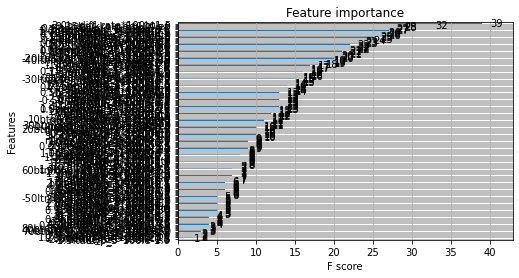

In [36]:
x_train,y_train,x_test,y_test = make_train_data()
# count_bit(x_train,y_train)
xgb_model = xgb_pred(x_train,y_train,x_test,y_test)
plot_importances(xgb_model,x_train)

In [48]:
importances = pd.DataFrame(
    {'features' : x_train.columns, 'importances' : xgb_model.feature_importances_}
)
importances.sort_values('importances', ascending=False).iloc[-20:]

,features,importances
15,0.4bedawp_5*100bt0.3,0.003073
185,diff_rate*100bt2.0,0.003008
64,-0.4ltdawp_1*100le-0.3,0.002992
177,0.9bediff_rate*100bt0.85,0.002976
80,-1.5ltdawp_5*100le-1.0,0.002928
119,2.0benikkeip_1*100bt1.5,0.002918
167,-50ltnikkei_volumep*100le-40,0.002895
156,80btnikkei_volumep*100be70,0.002873
173,0.7bediff_rate*100bt0.65,0.002836
180,1.15bediff_rate*100bt1.0,0.002802
